**Difference between autoencoder (deterministic) and variational autoencoder (probabilistic)**
![VAE](https://miro.medium.com/max/2000/1*ejNnusxYrn1NRDZf4Kg2lw@2x.png)


## Import Libraries

In [0]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import MNIST dataset and Data Preprocessing

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_test = y_test

In [0]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Data Visualization

y_train[20] =  4
y_train[500] =  3
y_train[3000] =  9
y_train[9000] =  6


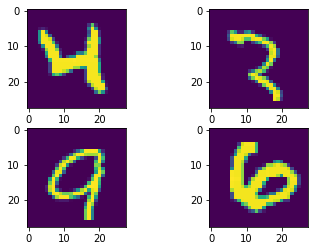

In [0]:
x_train_show = x_train.reshape(-1,28,28)
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train_show[20])
print('y_train[20] = ', y_train[20])

plt.subplot(222)
plt.imshow(x_train_show[500])
print('y_train[500] = ', y_train[500])

plt.subplot(223)
plt.imshow(x_train_show[3000])
print('y_train[3000] = ', y_train[3000])

plt.subplot(224)
plt.imshow(x_train_show[9000])
print('y_train[9000] = ', y_train[9000])
plt.show()

## Reparameterization 

In [0]:
# reparameterization trick: instead of sampling from Q(z|X), sample epsilon = N(0,1)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Set up network parameters

In [0]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
filters = 16
latent_dim = 2 # Change this later
epochs = 30
use_mse = True

## Build encoder model

In [0]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Build decoder model

In [0]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## Build VAE model = encoder + decoder¶


In [0]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

## Loss = reconstruction loss + KL loss



In [0]:
if use_mse:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= image_size * image_size # beta-value; change this parameter
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

## Compile model¶


In [0]:
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 69076       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    65089       encoder[1][2]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         encoder_input[0][0]              
________________________________________________________________________________________________

## Fit model¶


In [0]:
weights_file = 'vae_cnn_mnist.h5'
if os.path.exists(weights_file):
    vae.load_weights(weights_file)
    print('Loaded weights!')
else:
    # train the autoencoder
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    vae.save_weights('vae_cnn_mnist.h5')

Epoch 1/30
1875/1875 [==============================] - 8s 4ms/step - loss: 48.5996 - val_loss: 42.9844
Epoch 2/30
1875/1875 [==============================] - 8s 4ms/step - loss: 41.5546 - val_loss: 40.7059
Epoch 3/30
1875/1875 [==============================] - 8s 4ms/step - loss: 40.3424 - val_loss: 40.0146
Epoch 4/30
1875/1875 [==============================] - 8s 4ms/step - loss: 39.7366 - val_loss: 39.5602
Epoch 5/30
1875/1875 [==============================] - 8s 4ms/step - loss: 39.3444 - val_loss: 39.2354
Epoch 6/30
1875/1875 [==============================] - 8s 4ms/step - loss: 39.0698 - val_loss: 39.1695
Epoch 7/30
1875/1875 [==============================] - 8s 4ms/step - loss: 38.8859 - val_loss: 38.9900
Epoch 8/30
1875/1875 [==============================] - 8s 4ms/step - loss: 38.6644 - val_loss: 38.7917
Epoch 9/30
1875/1875 [==============================] - 8s 4ms/step - loss: 38.5251 - val_loss: 38.5098
Epoch 10/30
1875/1875 [==============================] - 8s 4ms/

## Compare Actual and Reconstructed Images

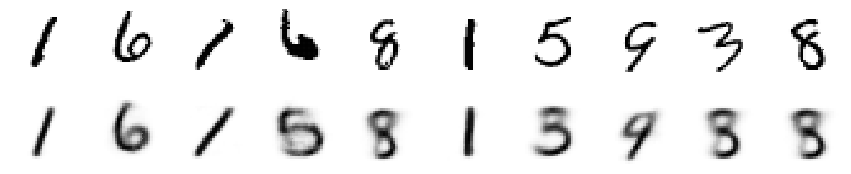

In [0]:
fig, axes = plt.subplots(2, 10, figsize=(15, 3))

def show(im):
    sns.heatmap(im.reshape((28, 28)), cmap='Greys', cbar=False, square=True, )

sample = np.random.randint(len(x_test), size=10)
reconst = vae.predict([x_test[sample], y_test[sample]])

for i in range(10):
    axes[0, i].get_xaxis().set_visible(False)
    axes[0, i].get_yaxis().set_visible(False)
    plt.sca(axes[0, i])
    show(x_test[sample[i]])
    axes[1, i].get_xaxis().set_visible(False)
    axes[1, i].get_yaxis().set_visible(False)
    plt.sca(axes[1, i])
    show(reconst[i])

plt.show()

## Display a 2D plot of the digit classes in the latent space

In [0]:
def plot_results(encoder, decoder, x_test, y_test, batch_size=128):
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

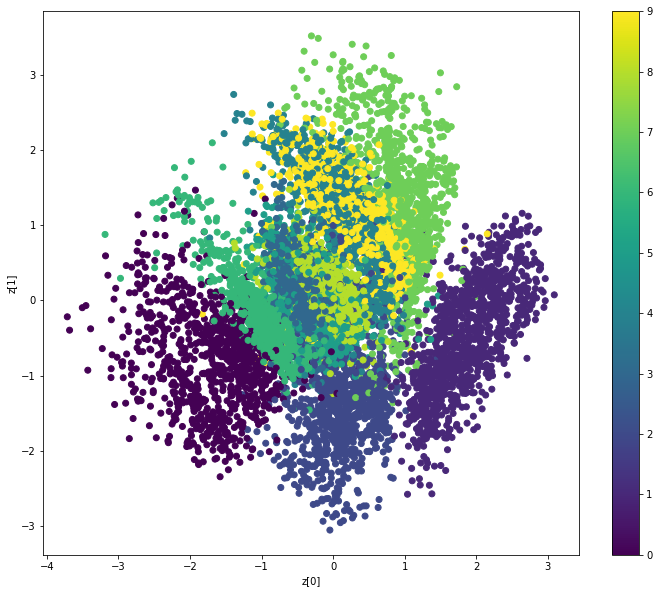

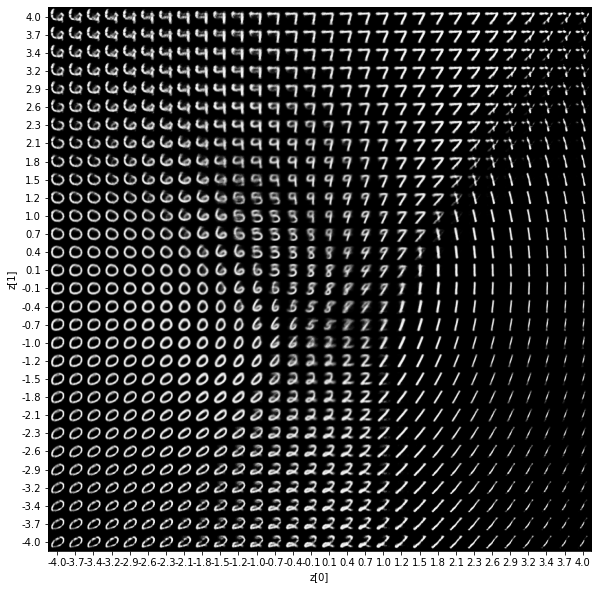

In [0]:
plot_results(encoder, decoder, x_test, y_test, batch_size=batch_size)